In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA


In [3]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/VIC.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

df['Time'] = np.arange(len(df.index))

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.5 MB/s eta 0:00:00


In [5]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
exog_train = np.array(train_data['Time'])

from pmdarima.arima import auto_arima
# Tự động chọn chỉ số AR, I, MA
model = auto_arima(y_train, exogenous=exog_train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Ước lượng mô hình ARIMAX với các chỉ số đã được chọn
model_fit = ARIMA(y_train, order=model.order, exog=exog_train).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17166.145, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17167.445, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17167.420, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17164.455, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17168.255, Time=2.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.164 seconds


In [6]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exog_test = np.array(test_data['Time'])
y_pred = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, exog=exog_test)

# print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
exog_val = np.array(val_data['Time'])
# print(exog_val)

expanded_exog_val = np.repeat(exog_val, repeats=3, axis=0)  # Lặp lại 3 lần
expanded_exog_val = expanded_exog_val.reshape(-1, 1)[:413]  # Điều chỉnh kích thước


y_pred_val =  model_fit.predict(start=len(train_data)+len(test_data), end=len(df)-1, exog=expanded_exog_val)

# print(y_pred_val)

In [7]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
exog_30day = np.array(range(1376, 1406))

expanded_exog_30day = np.repeat(exog_30day, repeats=15, axis=0)  # Lặp lại 3 lần
expanded_exog_30day = expanded_exog_30day.reshape(-1, 1)[:443]  # Điều chỉnh kích thước

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(df), end=len(df)+29, exog=expanded_exog_30day)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[107224.24844075 107224.24844075 107224.24844075 107224.24844075
 107224.24844075 107224.24844075 107224.24844075 107256.72972973
 107256.72972973 107256.72972973 107256.72972973 107256.72972973
 107256.72972973 107256.72972973 107256.72972973 107256.72972973
 107256.72972973 107256.72972973 107256.72972973 107256.72972973
 107256.72972973 107256.72972973 107289.21101871 107289.21101871
 107289.21101871 107289.21101871 107289.21101871 107289.21101871
 107289.21101871 107289.21101871]


In [8]:
# 7. Tính RMSE, MSE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

valid_mse = mean_squared_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred)

valid_rmse = np.sqrt(valid_mse)
test_rmse = np.sqrt(test_mse)

valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)*100
test_mape = mean_absolute_percentage_error(y_test, y_pred)*100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 50388.5401666184
Testing RMSE: 25357.314627808297
Validation MAE: 50144.13074361988
Testing MAE: 20865.25412965413
Validation MAPE: 91.67842283128469
Testing MAPE: 31.017204292956762


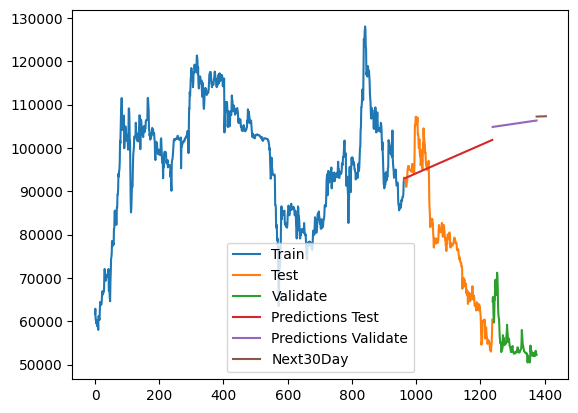

In [9]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test','Validate','Predictions Test','Predictions Validate','Next30Day'])
plt.show()

In [10]:
test_data.index

RangeIndex(start=963, stop=1238, step=1)